In [1]:
# pseudo-code
# chunks: chunks from the entire game
# component_assignment = []
# for model in models:
#     component_labels = model(chunks)
#     component_assignment.append(component_labels)
# json save
# json load
# nodes = []
# for i, component_labels in enumerate(component_assignment):
#     next_component_labels = component_assignment[i+1]
#     for label in np.unique(component_labels):
#         tos = next_component_labels[next_component_labels == label]
#         for to_label, to_weight in zip(np.unique(tos), np.bincount(tos))
#             nodes.append([label, to_label, to_weight])

In [2]:
import json

import numpy as np
import argparse
import random
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data
from scipy.io import loadmat

import sys
sys.path.append('/home/yangz2/projects/gmvae_and_gmmvae/pytorch/')
sys.path.append('../../1906-pcgml/pcgml-gmmVae-exp/modules/')
import vglc_with_path_encodings

from model.GMVAE import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/home/yangz2/projects/modules/')
from log_training_progress import email_training_progress

from tqdm import tqdm_notebook

In [3]:
num_epochs = 10000
num_components = 4

In [4]:
########################################################
## Input Parameters
#########################################################
parser = argparse.ArgumentParser(description='PyTorch Implementation of DGM Clustering')

## Used only in notebooks
parser.add_argument('-f', '--file',
                    help='Path for input file. First line should contain number of lines to search in')

## Dataset
parser.add_argument('--dataset', type=str, choices=['mnist'],
                    default='mnist', help='dataset (default: mnist)')
parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')

## GPU
parser.add_argument('--cuda', type=int, default=0,
                    help='use of cuda (default: 1)')
parser.add_argument('--gpuID', type=int, default=0,
                    help='set gpu id to use (default: 0)')

## Training
parser.add_argument('--epochs', type=int, default=num_epochs,
                    help='number of total epochs to run (default: 200)')
parser.add_argument('--batch_size', default=64, type=int,
                    help='mini-batch size (default: 64)')
parser.add_argument('--batch_size_val', default=200, type=int,
                    help='mini-batch size of validation (default: 200)')
parser.add_argument('--learning_rate', default=1e-3, type=float,
                    help='learning rate (default: 0.001)')
parser.add_argument('--decay_epoch', default=-1, type=int, 
                    help='Reduces the learning rate every decay_epoch')
parser.add_argument('--lr_decay', default=0.5, type=float,
                    help='Learning rate decay for training (default: 0.5)')

## Architecture
parser.add_argument('--num_classes', type=int, default=num_components,
                    help='number of classes (default: 10)')  # edited for this task
parser.add_argument('--gaussian_size', default=64, type=int,
                    help='gaussian size (default: 64)')
parser.add_argument('--input_size', default=3072, type=int,
                    help='input size (default: 784)')  # edited for this task

## Partition parameters
parser.add_argument('--train_proportion', default=1, type=float,
                    help='proportion of examples to consider for training only (default: 1.0)')

## Gumbel parameters
parser.add_argument('--init_temp', default=1.0, type=float,
                    help='Initial temperature used in gumbel-softmax (recommended 0.5-1.0, default:1.0)')
parser.add_argument('--decay_temp', default=1, type=int, 
                    help='Set 1 to decay gumbel temperature at every epoch (default: 1)')
parser.add_argument('--hard_gumbel', default=0, type=int, 
                    help='Set 1 to use the hard version of gumbel-softmax (default: 1)')
parser.add_argument('--min_temp', default=0.5, type=float, 
                    help='Minimum temperature of gumbel-softmax after annealing (default: 0.5)' )
parser.add_argument('--decay_temp_rate', default=0.013862944, type=float,
                    help='Temperature decay rate at every epoch (default: 0.013862944)')

## Loss function parameters
parser.add_argument('--w_gauss', default=2, type=float,
                    help='weight of gaussian loss (default: 1)')
parser.add_argument('--w_categ', default=1, type=float,
                    help='weight of categorical loss (default: 1)')
parser.add_argument('--w_rec', default=1, type=float,
                    help='weight of reconstruction loss (default: 1)')
parser.add_argument('--rec_type', type=str, choices=['bce', 'mse'],
                    default='bce', help='desired reconstruction loss function (default: bce)')

## Others
parser.add_argument('--verbose', default=0, type=int,
                    help='print extra information at every epoch.(default: 0)')

args = parser.parse_args()

In [5]:
def open_json_as_nparray(json_fname):
    with open(json_fname, 'r') as json_f:
        return np.array(json.load(json_f))
    
chunks_int = open_json_as_nparray('/home/yangz2/projects/gmvae_and_gmmvae/data/smba_chunks_int.json')
chunks_onehot = np.eye(len(np.unique(chunks_int)))[chunks_int]
print(chunks_onehot.shape)

chunks_onehot = chunks_onehot.reshape(
    chunks_onehot.shape[0], 
    chunks_onehot.shape[1] * chunks_onehot.shape[2] * chunks_onehot.shape[3]
)
print(chunks_onehot.shape)

(2698, 16, 16, 12)
(2698, 3072)


In [6]:
GAME = 'smba'
RESULTS_DIR = '/home/yangz2/projects/gmvae_and_gmmvae/results/'

In [7]:
for i in tqdm_notebook([2, 4, 6, 8, 10, 15, 20, 30, 40, 50]):
    
    args.num_classes = i
    gmvae = GMVAE(args)
    gmvae.network.load_state_dict(torch.load(f'{RESULTS_DIR}/{GAME}_gmvae_trained_pths/{GAME}_gmvae_{i}_10000.pth', map_location=torch.device('cpu')))
    
    x = torch.from_numpy(chunks_onehot).float()
    for l in gmvae.network.inference.inference_qyx:
        x = l(x)
    labels = x[2].detach().numpy().argmax(axis=1)

    with open(f'{RESULTS_DIR}/{GAME}_gmvae_component_evolution/{i}.json', 'w+') as json_f:
        json.dump(labels.tolist(), json_f)

In [8]:
component_assignment = {}
for i in reversed([2, 4, 6, 8, 10, 15, 20, 30, 40, 50]):
    with open(f'{RESULTS_DIR}/{GAME}_gmvae_component_evolution/{i}.json', 'r') as json_f:
        component_assignment[i] = np.array(json.load(json_f))

In [9]:
component_assignment

{50: array([27, 27, 27, ..., 25, 25, 25]),
 40: array([13, 13, 13, ..., 13, 13, 13]),
 30: array([21,  6,  6, ...,  5,  5, 13]),
 20: array([15, 15, 15, ...,  9, 10, 10]),
 15: array([10,  3, 10, ...,  5,  3,  3]),
 10: array([7, 6, 7, ..., 3, 3, 3]),
 8: array([3, 3, 3, ..., 1, 7, 2]),
 6: array([1, 1, 1, ..., 0, 0, 4]),
 4: array([3, 3, 3, ..., 2, 2, 3]),
 2: array([0, 0, 0, ..., 0, 0, 0])}

In [10]:
list(reversed([2, 4, 6, 8, 10, 15, 20, 30, 40, 50]))[4:-1]

[15, 10, 8, 6, 4]

In [58]:
edges = []
widths = []

num_components_s = [20, 10]

for i, num_component in enumerate(num_components_s[:-1]):
    
    curr_labels = component_assignment[num_component]
    prev_labels = component_assignment[num_components_s[i+1]]
    
    for label in np.unique(curr_labels):
        
        froms = prev_labels[curr_labels == label]
        total_chunks = np.sum(curr_labels == label)
        
        for from_label, from_weight in zip(np.unique(froms), np.bincount(froms)):
            edges.append([f'{num_component}_{label+1}', f'{num_components_s[i+1]}_{from_label+1}'])
            widths.append(from_weight / total_chunks)

In [59]:
edges = np.array(edges)

In [67]:
np.median(widths)

0.03875968992248062

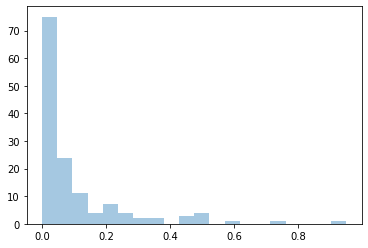

In [62]:
sns.distplot(widths, kde=False)
plt.show()

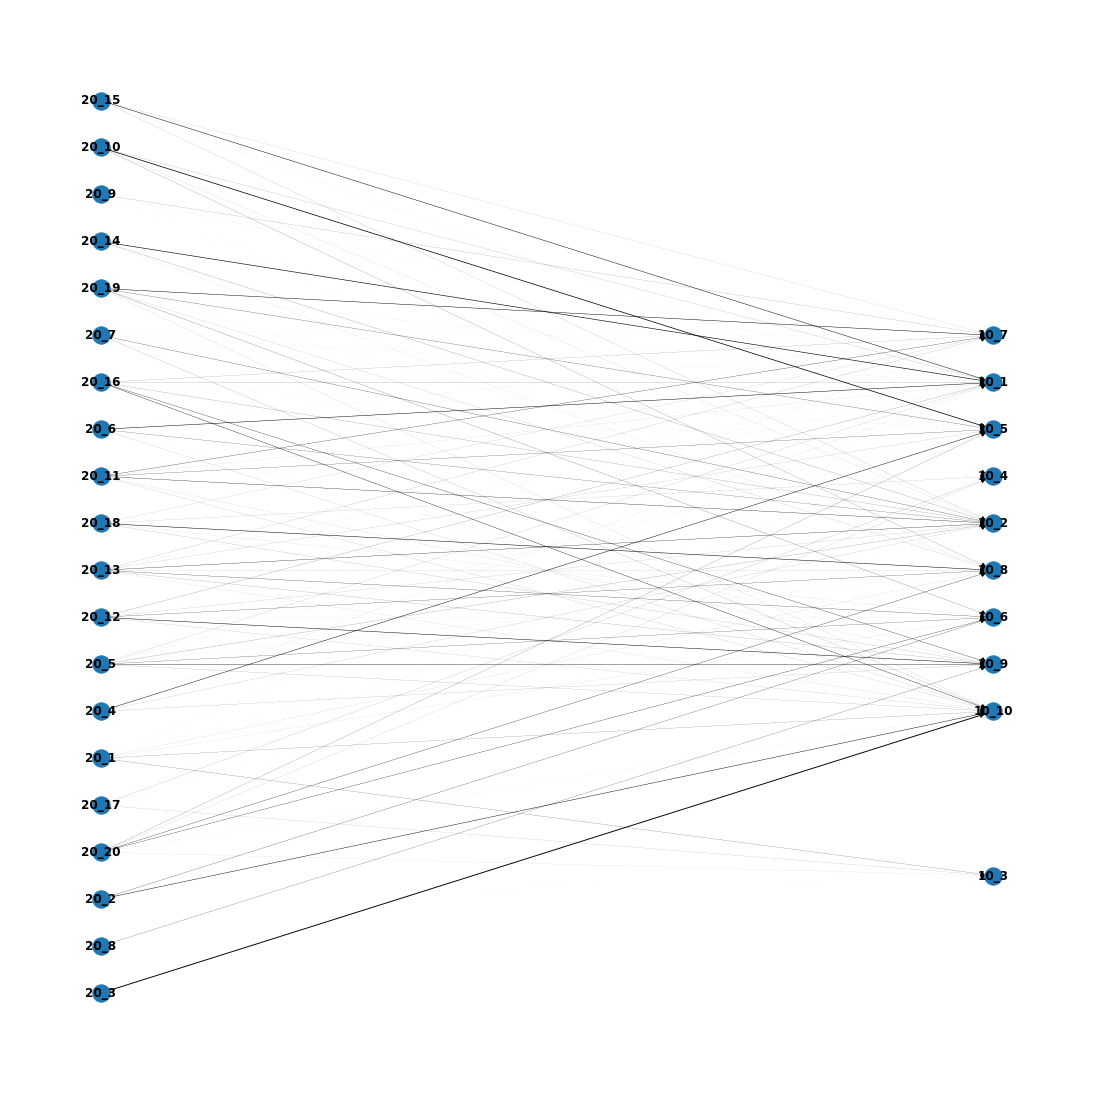

In [49]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

plt.figure(figsize=(15, 15))

G = nx.DiGraph()
ed = edges

G.add_edges_from(ed)
pos = graphviz_layout(G, prog='dot', args="-Grankdir=LR")
nx.draw(G,with_labels=True,pos=pos, font_weight='bold', width=widths)